In [1]:

import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quantstats as qs
import copy
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from datetime import datetime, timedelta
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA, plotting
from pypfopt import hierarchical_portfolio
from pypfopt import plotting
from metrics import *


DATA_DIR = (os.getcwd() + "/data/")
PREDICTION_DIR = (os.getcwd() + "/predictions_new/")
start_date = '2014-01-01'
end_date = "2019-11-30"
# Get fundamental data for each stock in the ticker and append to the dataframe


def get_all_symbols():
    return [v.strip('.csv') for v in os.listdir(DATA_DIR)]

def get_current_predictions():
    return [v.strip('_predictions.csv') for v in os.listdir(PREDICTION_DIR)]


tickers = get_all_symbols()
predicted_tickers = get_current_predictions()

sample_index = pd.read_csv(DATA_DIR + 'AAPL.csv', index_col='Date', parse_dates=True)
mask = (sample_index.index >= start_date) & (sample_index.index <= end_date)
sample_index = sample_index.loc[mask]


In [2]:
def get_top_n_tickers(year, month, n):
    #print("Getting top n tickers for year: " + str(year) + " month: " + str(month))
    results = []
    for ticker in get_current_predictions():
        df = pd.read_csv(PREDICTION_DIR + ticker + '_predictions.csv', index_col='Date', parse_dates=True)
        mask = (df.index.year == year) & (df.index.month == month)
        df = df.loc[mask]
        #print(ticker, df['Next Month Returns Predictions'][0])
        results.append((ticker, df['Next Month Returns Predictions'][0]))
    
    #print(results)
    results.sort(key=lambda x: x[1], reverse=True)
    tickers = [i[0] for i in results[:n]]
    pred_vector = [i[1] for i in results[:n]]
    #print(pred_vector)
    #print(year, month)
    return tickers, pred_vector

def get_close_prices(year, month, d, tickers):
    df = pd.DataFrame()
    days = d * 365
    target_date = datetime(year, month, 1) - timedelta(days=days)
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        mask = (data.index >= target_date) & (data.index <= datetime(year, month, 1))
        data = data.loc[mask]
        df[ticker] = data['Close']
        df.index = data.index

    return df


def generate_predicted_historical_returns(year, month, d, tickers):
    d = d * 365
    target_date = datetime(year, month, 1) - timedelta(days=d)
    df = pd.DataFrame()
    for ticker in tickers:
        prediction = pd.read_csv(PREDICTION_DIR + ticker + '_predictions.csv', index_col='Date', parse_dates=True)
        mask = (prediction.index >= target_date) & (prediction.index <= datetime(year, month, 1))
        prediction = prediction.loc[mask]
        df[ticker] = prediction['Next Month Returns Predictions']
        df.index = prediction.index
    return df
    


def get_top_n_tickers_combined(start_year, start_month, end_year, end_month, n):
    output = []
    pred_vectors = []
    curr_year, curr_month = start_year, start_month
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        tickers, pred_vector = get_top_n_tickers(curr_year, curr_month, n)
        output.append(tickers)
        pred_vectors.append(pred_vector)
        
        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
    return output, pred_vectors


def generate_close_data(tickers, month, year):
    df = pd.DataFrame()
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        data = data.loc[data.index.month == month]
        data = data.loc[data.index.year == year]
        df[ticker] = data['Close']
        df.index = data.index
    return df


def generate_all_close_data(tickers, start_year, start_month, end_year, end_month):
    output = pd.DataFrame()
    curr_year, curr_month = start_year, start_month
    curr_idx = 0
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        data = generate_close_data(tickers[curr_idx], curr_month, curr_year)
        output = pd.concat([output, data], axis=0, join='outer')
        output = output.reset_index(drop=True)
        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
        curr_idx += 1
        
    output.index = sample_index.index
    return output

def plot_weights(weights):
    pd.Series(weights).plot.pie(figsize=(10, 10))
    return 
        
        
    


In [3]:
def generate_mv_models(start_month, start_year, end_month, end_year, d, n):
    
    curr_year, curr_month = start_year, start_month
    dfs = {
        "d": [],
        "dfs": []
    }
    curr_max = 0
    curr_model = None
    
    for d in range(1, 4):
        df = {
        'sharpes': [],
        'expected_return': [],
        'annual_volatility': [],
        'num_stocks': [],
        'weights':[]
        }
    #while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        for i in range(25, 275, 25):
            tickers, pred_vector = get_top_n_tickers(curr_year, curr_month, i)
            close_data = get_close_prices(curr_year, curr_month, d, tickers)
            predicted_returns = generate_predicted_historical_returns(curr_year, curr_month, d, tickers)
            #print(close_data)
            #print(predicted_returns)
            mu = predicted_returns.mean()
            #mu = expected_returns.mean_historical_return(close_data)
            #print(mu)
            S = CovarianceShrinkage(close_data).ledoit_wolf()
            #print(S)\
            ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1))
            ef.add_objective(objective_functions.L2_reg, gamma=0.1)
            raw_weights = ef.max_sharpe()
            cleaned_weights = ef.clean_weights()
            #print(pd.Series(cleaned_weights).plot.pie(figsize=(10, 10)))
            # ef.save_weights_to_file("weights.csv")  # saves to file
            #print(cleaned_weights)
            #print(raw_weights)
            ef.portfolio_performance(verbose=False)
        
            ex_return = ef.portfolio_performance()[0]
            df['expected_return'].append(ex_return)
            df['num_stocks'].append(i)
            df['annual_volatility'].append(ef.portfolio_performance()[1])
            df['sharpes'].append(ef.portfolio_performance()[2])
            df['weights'].append(cleaned_weights)
            
            if ef.portfolio_performance()[2] > curr_max:
                curr_max = ef.portfolio_performance()[2]
                curr_model = ef
        #print(ef.portfolio_performance()[0]) # sharpe ratio
        dfs["d"].append(d)
        dfs['dfs'].append(df)
        
        
        
    # Plot Graph
    #plt.plot(df['num_stocks'], df['sharpes'])
    #print(dfs)
    return dfs, curr_model

In [4]:
# Generate Mean Variance Models
results, best_model = generate_mv_models(1, 2014, 1, 2018, 3, 50)


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
C:\Users\yinki\AppData\Local\Packages\Pytho

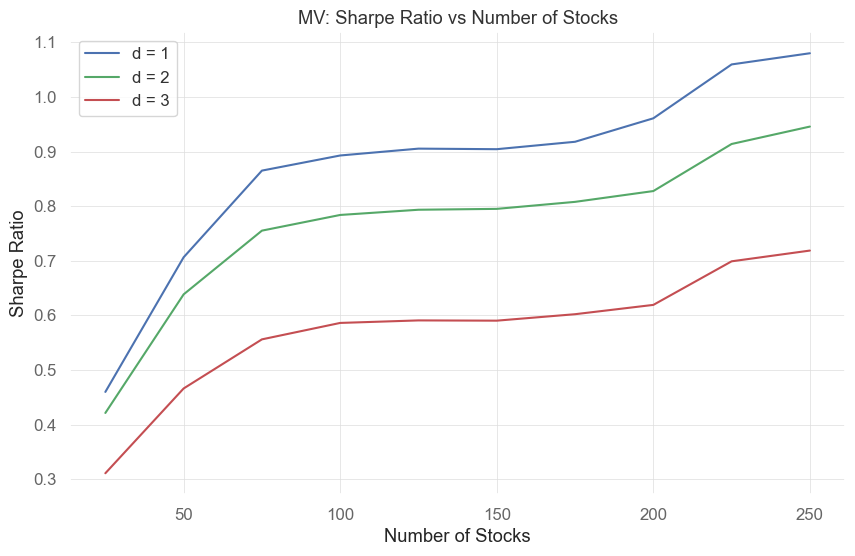

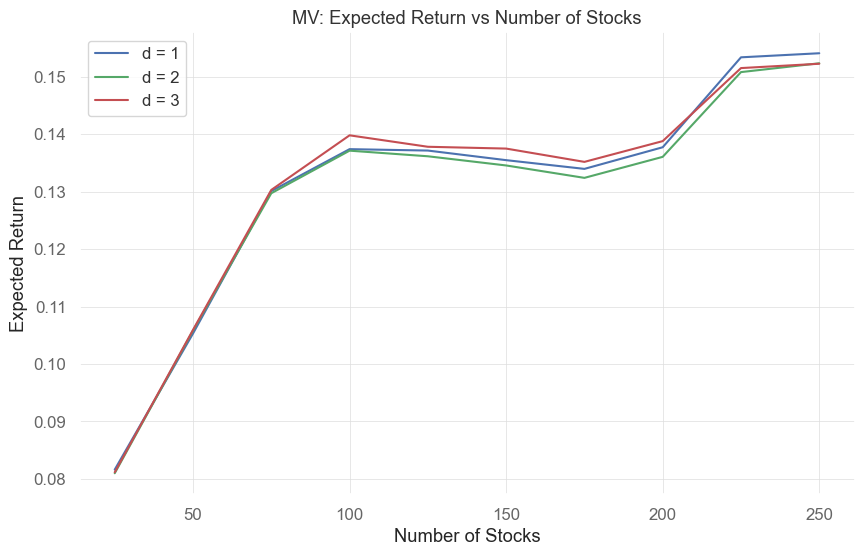

In [6]:
#Plot Graph results
#print(results)
# Make plot grid 2x2
#fig, axs = plt.subplots(2, 2, figsize=(10, 10))
d = [1, 2, 3]
for i, result in enumerate(results['dfs']):
    #print(i, result)
    plt.plot(result['num_stocks'], result['sharpes'])
    plt.xlabel('Number of Stocks')
    plt.ylabel('Sharpe Ratio')
    #plt.legend(['d = ' + str(d[i])])
    plt.title('MV: Sharpe Ratio vs Number of Stocks')
plt.legend(['d = 1', 'd = 2', 'd = 3'])
plt.show()

for i, result in enumerate(results['dfs']):
    #print(i, result)
    plt.plot(result['num_stocks'], result['expected_return'])
    plt.xlabel('Number of Stocks')
    plt.ylabel('Expected Return')
    # plt.legend(['d = ' + str(d[i])])
    plt.title('MV: Expected Return vs Number of Stocks')
plt.legend(['d = 1', 'd = 2', 'd = 3'])
plt.show()



Expected annual return: 15.4%
Annual volatility: 12.4%
Sharpe Ratio: 1.08
Performance of best portfolio: (0.15411300072880377, 0.12419634392351452, 1.0798466081368414)
Best Portfolio Weights: OrderedDict([('WAT', 0.0), ('HSIC', 0.0), ('APA', 0.0), ('ECL', 0.0), ('AOS', 0.01858), ('FAST', 0.0), ('C', 0.0), ('RCL', 0.0), ('URI', 0.0), ('PNR', 0.0), ('BBY', 0.0), ('FCX', 0.0), ('GILD', 0.0), ('TSN', 0.04165), ('VLO', 0.0), ('SWK', 0.0), ('SHW', 0.0), ('MCK', 0.0), ('EFX', 0.0), ('NEE', 0.0), ('VMC', 0.0), ('RJF', 0.08614), ('IDXX', 0.0), ('VFC', 0.0), ('CSGP', 0.07911), ('EBAY', 0.0), ('MCD', 0.0), ('ODFL', 0.0), ('MSI', 0.0), ('DVN', 0.0), ('GLW', 0.0), ('DRI', 0.0), ('IBM', 0.0), ('BIIB', 0.0), ('CNP', 0.0), ('TROW', 0.0), ('INCY', 0.0), ('MS', 0.0), ('UNP', 0.0), ('AMZN', 0.0), ('RTX', 0.0), ('AMAT', 0.0), ('CVX', 0.0), ('TT', 0.0), ('ALB', 0.1), ('MHK', 0.0), ('EOG', 0.0), ('SLB', 0.0), ('SJM', 0.0), ('VZ', 0.0), ('FMC', 0.02046), ('ETN', 0.0), ('CMS', 0.0), ('AAPL', 0.07361), ('PH', 

<AxesSubplot: >

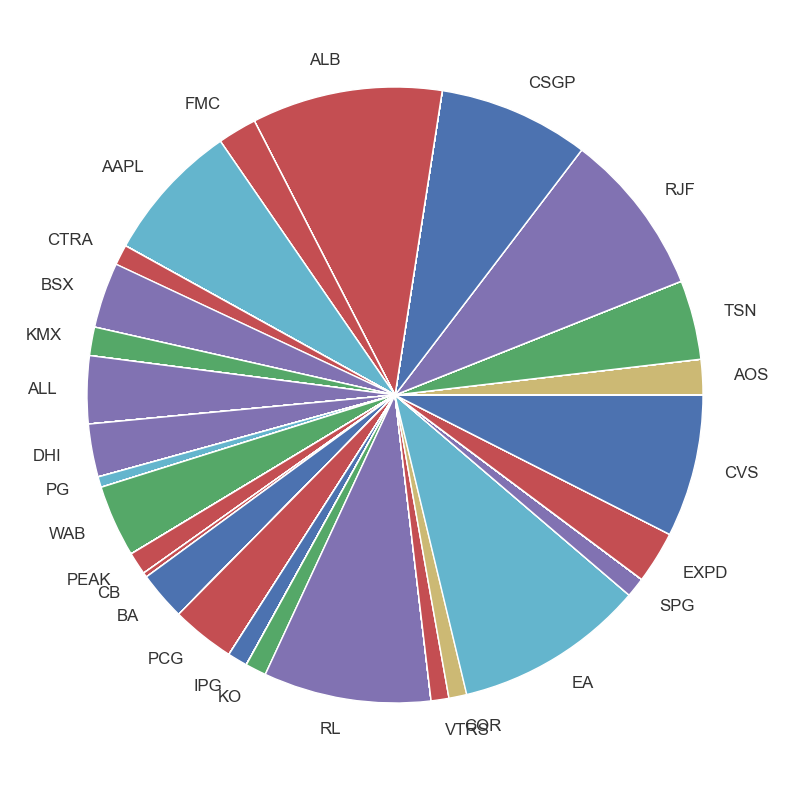

In [26]:
# Get best Portfolio based on sharpe ratio
# print(results)
print(
    f"Performance of best portfolio: {best_model.portfolio_performance(verbose=True)}")
print(f"Best Portfolio Weights: {best_model.clean_weights()}")

# Plotting
pd.Series(best_model.clean_weights()).plot.pie(figsize=(10, 10))


In [8]:
# Comparing with Quantstats Benchmark, Testing weights

# Maximum Sharpe Weighted Portfolio, testing with Optimized Weights
weights = results['dfs'][0]['weights'][-1] # Returns orderedDict of Stocks
#print(weights)

# For each stock, get the weights, get daily historical return from 2014-2018
# Get SP500 Benchmark
sp500 = pd.read_csv(DATA_DIR + 'GSPC.csv', index_col='Date', parse_dates=True)
mask = (sp500.index >= datetime(2014, 1, 1)) & (sp500.index <= datetime(2019, 12, 31))
sp500 = sp500.loc[mask]
sp500 = sp500['Close']
sp500 = sp500.pct_change().dropna()
#print(sp500)

returns = pd.DataFrame()
for ticker, weight in weights.items():
    
    # Get historical data for each stock
    if weight == 0:
        continue
    data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
    mask = (data.index >= datetime(2014, 1, 1)) & (data.index <= datetime(2019, 11, 30))
    data = data.loc[mask]
    data = data['Close']
    data = data.pct_change().dropna()
    returns[ticker] = data * weight

returns['Portfolio'] = returns.sum(axis=1)
optimized_portfolio = returns['Portfolio']


qs.reports.html(optimized_portfolio, benchmark=sp500, output='stats.html', title='Optimized Portfolio vs SP500')
    
 


: 

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-01-03   2014-01-03
End Period                 2019-11-29   2019-11-29
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          118.76%      97.84%
CAGR﹪                     9.58%        8.3%

Sharpe                     0.83         0.84
Prob. Sharpe Ratio         97.69%       97.83%
Smart Sharpe               0.83         0.84
Sortino                    1.15         1.17
Smart Sortino              1.15         1.17
Sortino/√2                 0.82         0.83
Smart Sortino/√2           0.81         0.83
Omega                      1.16         1.16

Max Drawdown               -29.63%      -25.84%
Longest DD Days            435          435
Volatility (ann.)          17.9%        15.08%
R^2                        1.0          1.0
Information Ratio          -0.05        -0.05
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-09-21,2018-12-24,2019-11-29,435,-25.841988,-22.889427
2,2015-06-23,2016-02-11,2016-05-24,337,-18.145527,-16.791036
3,2018-01-29,2018-04-02,2018-05-22,114,-9.491732,-9.455965
4,2014-09-19,2014-10-16,2014-10-29,41,-8.626543,-8.515980
5,2014-03-10,2014-04-11,2014-05-09,61,-6.520184,-5.762951


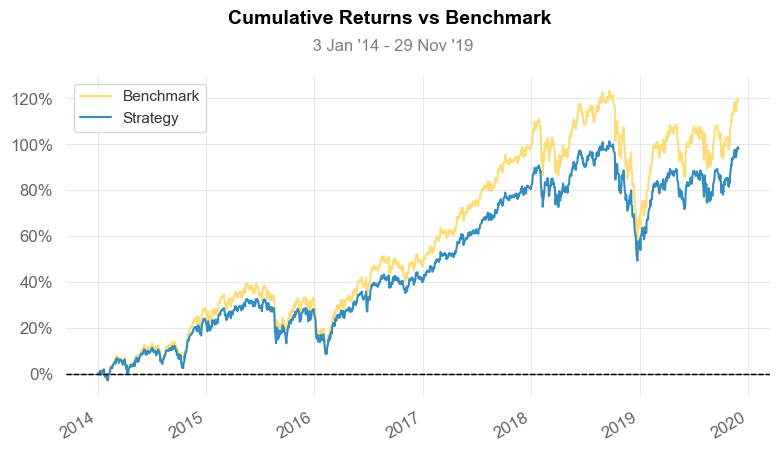

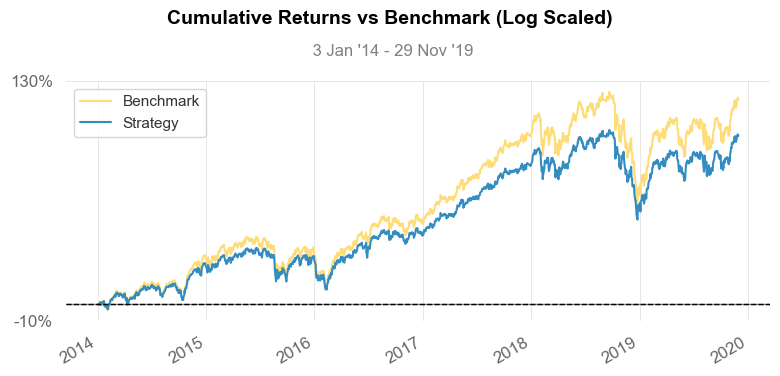

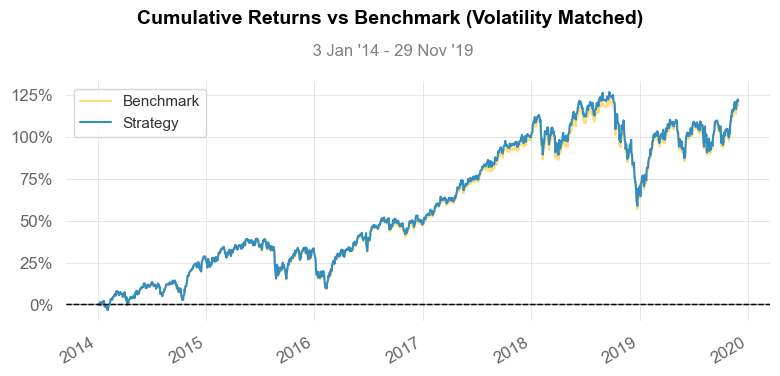

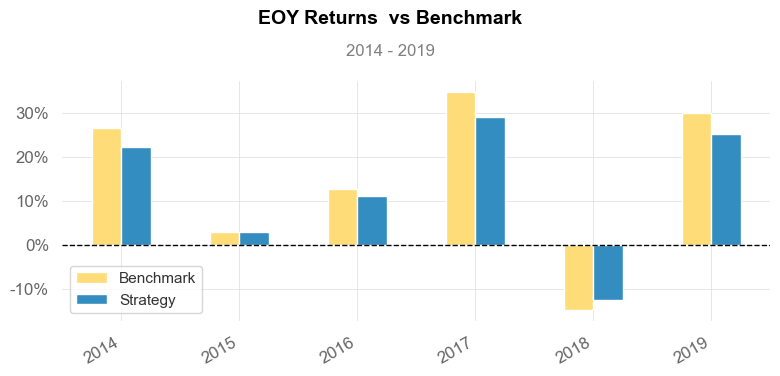

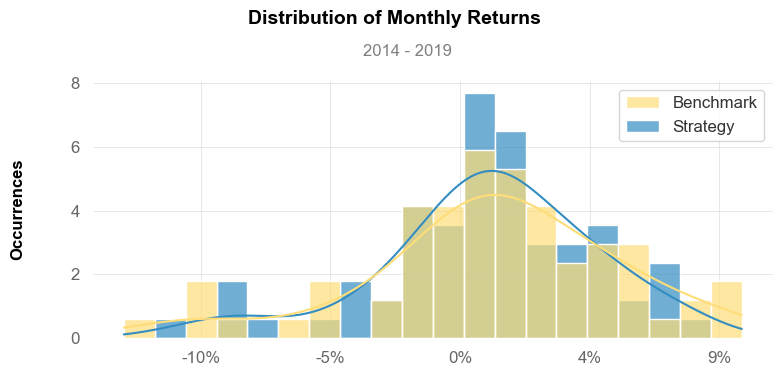

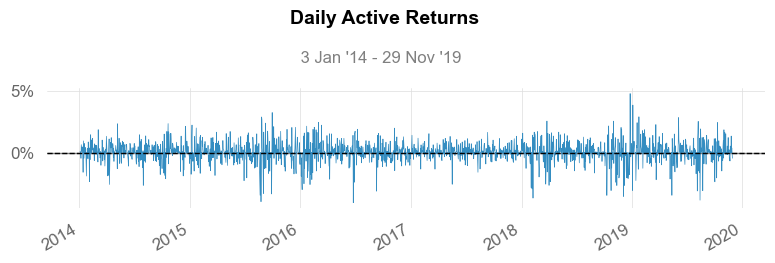

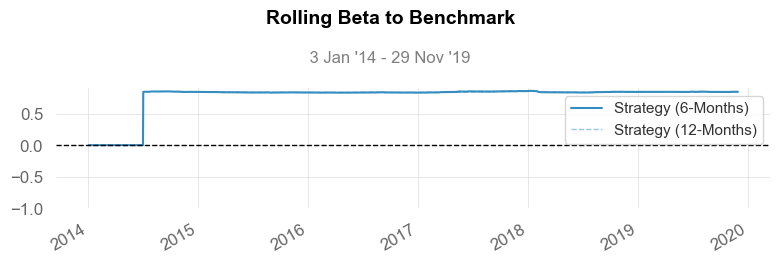

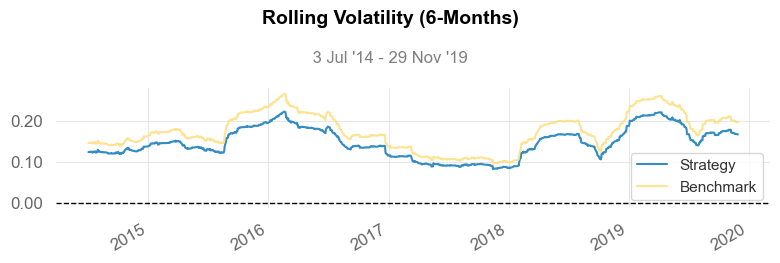

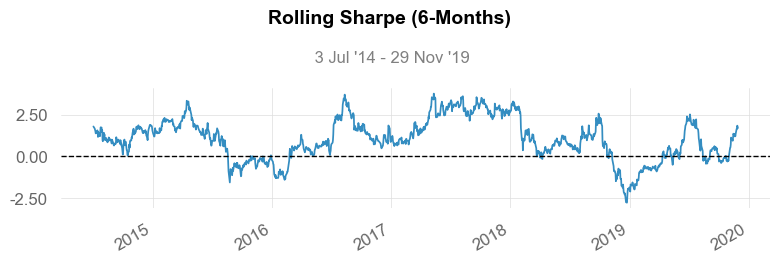

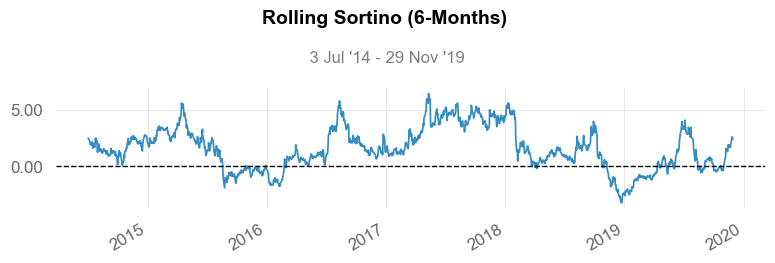

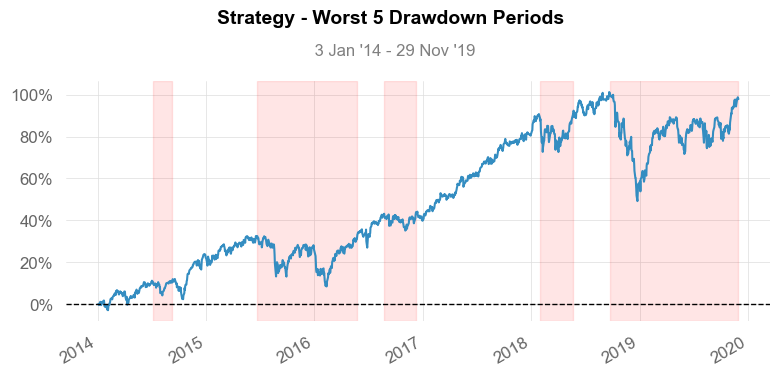

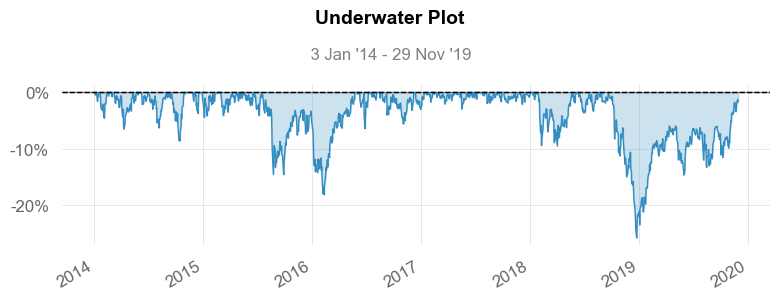

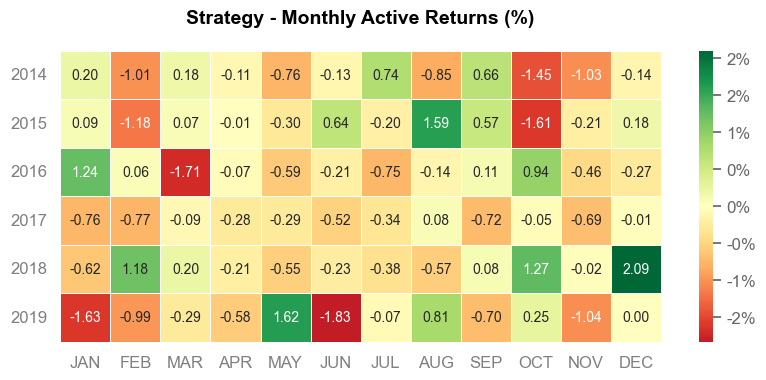

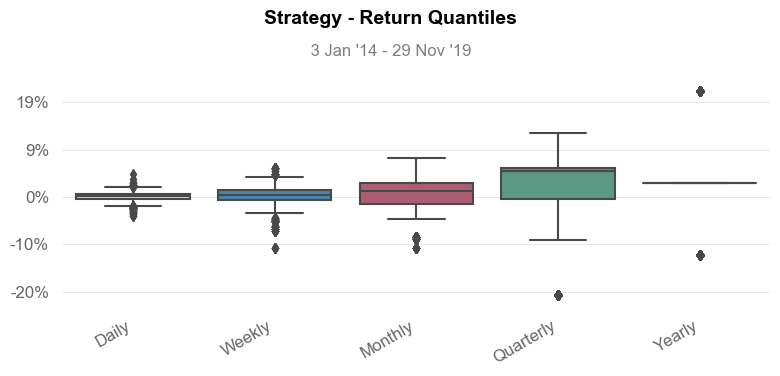

In [29]:
# Comparing with Quantstats Benchmark, Testing weights

# Maximum Sharpe Weighted Portfolio, testing with Native Weights
weights = results['dfs'][0]['weights'][-1]  # Returns orderedDict of Stocks
# print(weights)

# For each stock, get the weights, get daily historical return from 2014-2018

naive_returns = pd.DataFrame()
num_stocks = len(weights)
each_weight = 1 / num_stocks
for ticker, weight in weights.items():

    # Get historical data for each stock
    if weight == 0:
        continue
    data = pd.read_csv(DATA_DIR + ticker + '.csv',
                       index_col='Date', parse_dates=True)
    mask = (data.index >= datetime(2014, 1, 1)) & (
        data.index <= datetime(2019, 12, 31))
    data = data.loc[mask]
    data = data['Close']
    data = data.pct_change().dropna()
    returns[ticker] = data * each_weight

returns['Portfolio'] = returns.sum(axis=1)
portfolio = returns['Portfolio']


qs.reports.full(optimized_portfolio, benchmark=portfolio)


In [6]:
# Build Vector of Predicted Returns
# For each month, get top n stocks

result, predicted_vectors = get_top_n_tickers_combined(2014, 1, 2019, 11, 50)

In [7]:
output = generate_all_close_data(result, 2014, 1, 2019, 11)

In [26]:
mu = expected_returns.mean_historical_return(output)
S = CovarianceShrinkage(output).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1))
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


NameError: name 'output' is not defined

In [3]:
start_date = '2010-01-01'
end_date = "2019-11-30"

sample_index = pd.read_csv(DATA_DIR + 'AAPL.csv', index_col='Date', parse_dates=True)
mask = (sample_index.index >= start_date) & (sample_index.index <= end_date)
sample_index = sample_index.loc[mask]

In [10]:
def generate_close_data(tickers, month, year):
    df = pd.DataFrame()
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        data = data.loc[data.index.month == month]
        data = data.loc[data.index.year == year]
        df[ticker] = data['Close']
        df.index = data.index
    return df

def generate_past_close_data(tickers, month, year):
    df = pd.DataFrame()
    
    data = pd.read_csv('close_data_3year.csv', index_col='Date', parse_dates=True)
    data = data[tickers]
    mask = (data.index.month <= month) & (data.index.year <= year)
    data = data.loc[mask]
    return data


def generate_all_close_data(tickers, start_year, start_month, end_year, end_month):
    output = pd.DataFrame()
    curr_year, curr_month = start_year, start_month
    curr_idx = 0
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        data = generate_close_data(tickers[curr_idx], curr_month, curr_year)
        output = pd.concat([output, data], axis=0, join='outer')
        output = output.reset_index(drop=True)
        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
        curr_idx += 1
        
    output.index = sample_index.index
    return output

generate_past_close_data(['AAPL', 'MSFT', 'AMZN'], 11, 2019)
mu = expected_returns.mean_historical_return(generate_past_close_data(['AAPL', 'MSFT', 'AMZN'], 11, 2019))
cov = CovarianceShrinkage(generate_past_close_data(['AAPL', 'MSFT', 'AMZN'], 11, 2019)).ledoit_wolf()
ef = EfficientFrontier(mu, cov)
weights = ef.max_sharpe()
print(weights)
for w in weights:
    print(weights[w])

OrderedDict([('AAPL', 0.280669041956151), ('MSFT', 0.3522316822775382), ('AMZN', 0.3670992757663107)])
0.280669041956151
0.3522316822775382
0.3670992757663107


In [19]:
import pandas as pd
import numpy as np
import pypfopt as popt

# Load stock data
stock_data = pd.read_csv('close_data_3year.csv')
result, predicted_vectors = get_top_n_tickers_combined(2014, 1, 2019, 11, 25)
#output = generate_all_close_data(result, 2014, 1, 2019, 11)

# Convert dates to DateTime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Set start and end dates for rebalancing
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2019-11-30')
portfolio_weights = pd.DataFrame(columns=['Date', 'Ticker', 'Weight'])

# Define function to rebalance portfolio
def rebalance_portfolio(stock_tickers, current_date):
    global portfolio_weights
    # Filter stock data based on input tickers and current date
    #relevant_data = stock_data[stock_tickers]
    #relevant_data = stock_data[(stock_data['Date'] <= current_date)]

    # Calculate expected returns and covariances
    #tickers, pred_vector = get_top_n_tickers(current_date.year, current_date.month, 25)
    output = generate_past_close_data(stock_tickers, current_date.month, current_date.year)
    mu = expected_returns.mean_historical_return(output)
    covariance_matrix = CovarianceShrinkage(output).ledoit_wolf()

    # Define portfolio objective and constraints
    objective = popt.EfficientFrontier(mu, covariance_matrix, weight_bounds=(0, 0.1))
    objective.add_objective(popt.objective_functions.L2_reg, gamma=0.1)
    raw_weights = objective.max_sharpe()
    cleaned_weights = objective.clean_weights()
    #print(cleaned_weights)
    # Optimize portfolio
    #optimized_portfolio = objective.optimize(expected_returns, covariance_matrix)

    # Rebalance portfolio based on optimized weights
    for stock_index, stock_ticker in enumerate(stock_tickers):
        # Add optimized weights to portfolio weights DataFrame
        weight = cleaned_weights[stock_ticker]
        new_row = pd.DataFrame({'Date': current_date, 'Ticker': stock_ticker, 'Weight': weight},  index=[0])
        new_result = pd.concat([portfolio_weights, new_row], axis=0, ignore_index=True)
        portfolio_weights = new_result
        #print(portfolio_weights)
        #portfolio_weights.loc[(portfolio_weights['Ticker'] == stock_ticker) & (portfolio_weights['Date'] == current_date)] 
        #= cleaned_weights[stock_index]
        #stock_data.loc[(stock_data['Ticker'] == stock_ticker) & (stock_data['Date'] == current_date), 'Weight'] = optimized_portfolio.clean_weights()[stock_index]

# Rebalance portfolio monthly from start to end date
current_date = start_date
while current_date <= end_date:
    # Get input vector of stock tickers for the current month
    stock_tickers, pred_vector = get_top_n_tickers(current_date.year, current_date.month, 25)
    print(stock_tickers)

    # Rebalance portfolio using the input tickers
    rebalance_portfolio(stock_tickers, current_date)

    # Increment the date to the next month
    current_date = current_date + pd.DateOffset(months=1)

['WAT', 'HSIC', 'APA', 'ECL', 'AOS', 'FAST', 'C', 'RCL', 'URI', 'PNR', 'BBY', 'FCX', 'GILD', 'TSN', 'VLO', 'SWK', 'SHW', 'MCK', 'EFX', 'NEE', 'VMC', 'RJF', 'IDXX', 'VFC', 'CSGP']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['REGN', 'GEN', 'CPRT', 'WFC', 'ODFL', 'SWKS', 'CI', 'TFX', 'JBHT', 'MRO', 'EL', 'MTCH', 'TSN', 'EFX', 'J', 'MCK', 'CDNS', 'WAB', 'BA', 'CSX', 'SLB', 'MOS', 'JKHY', 'GILD', 'CSGP']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['PXD', 'MAS', 'VRTX', 'IBM', 'TSN', 'IT', 'PH', 'BKR', 'NOC', 'AMZN', 'NEM', 'DD', 'FI', 'TMO', 'SBUX', 'TRV', 'GLW', 'AME', 'REGN', 'ZBRA', 'AMD', 'TROW', 'STZ', 'CI', 'AMT']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['STLD', 'SBUX', 'POOL', 'CTAS', 'NOC', 'BBY', 'PPG', 'CI', 'RCL', 'LUV', 'PCAR', 'EXPD', 'TSCO', 'CSGP', 'STZ', 'BIIB', 'HSY', 'APH', 'BKR', 'CTRA', 'CMA', 'MNST', 'TRMB', 'HOLX', 'HST']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['INCY', 'RVTY', 'BA', 'NUE', 'CPRT', 'CCL', 'FCX', 'ADBE', 'VTRS', 'ALK', 'CPT', 'CTSH', 'WDC', 'PSA', 'RSG', 'MRO', 'POOL', 'SYK', 'KR', 'TYL', 'ROL', 'TT', 'TRV', 'NOC', 'CVS']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['REGN', 'WFC', 'SWKS', 'RJF', 'URI', 'HAS', 'INTU', 'BIIB', 'HSY', 'ODFL', 'SNA', 'WBA', 'NI', 'GILD', 'CTAS', 'NEM', 'OXY', 'LUV', 'KEY', 'OKE', 'DHR', 'JKHY', 'NKE', 'RHI', 'IT']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['URI', 'AAPL', 'ADM', 'HAL', 'HSY', 'MU', 'POOL', 'MCHP', 'HAS', 'AIG', 'HUM', 'DVN', 'DOV', 'CMI', 'ROL', 'RF', 'PXD', 'D', 'PWR', 'LRCX', 'VTRS', 'CTRA', 'DVA', 'FMC', 'PH']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['HES', 'TRV', 'IVZ', 'APH', 'RVTY', 'WDC', 'NDSN', 'MU', 'SWK', 'VTRS', 'MCO', 'JKHY', 'POOL', 'HUM', 'OMC', 'PHM', 'RMD', 'HON', 'LUV', 'BDX', 'JBHT', 'RHI', 'SHW', 'BBWI', 'MLM']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['JBHT', 'RCL', 'BIO', 'RVTY', 'AXP', 'AOS', 'HST', 'GEN', 'KR', 'MMM', 'HAL', 'BA', 'PXD', 'MCHP', 'CMS', 'COO', 'LMT', 'DVA', 'IVZ', 'BWA', 'AMAT', 'WFC', 'IEX', 'INCY', 'CB']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['APH', 'NTAP', 'MU', 'SCHW', 'GLW', 'FCX', 'WAB', 'IPG', 'AME', 'RVTY', 'MAR', 'CTSH', 'SWKS', 'WRB', 'ROP', 'EXPD', 'AFL', 'EBAY', 'AES', 'TT', 'ADM', 'BBWI', 'RMD', 'MHK', 'CHD']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['WDC', 'ROL', 'IPG', 'NDSN', 'APA', 'NSC', 'WRB', 'AAPL', 'GLW', 'LRCX', 'REGN', 'TRMB', 'PNR', 'EA', 'PLD', 'EG', 'SWKS', 'UHS', 'ALK', 'MCO', 'MNST', 'WAB', 'ANSS', 'VTR', 'IVZ']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['MHK', 'FICO', 'INCY', 'AMT', 'CAT', 'NVR', 'TSCO', 'TECH', 'CMI', 'ALK', 'RSG', 'INTC', 'PH', 'VRTX', 'RHI', 'AMZN', 'NI', 'WMB', 'JNJ', 'NSC', 'KR', 'NEM', 'CTRA', 'SWK', 'IT']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['INCY', 'AMD', 'ADI', 'TRMB', 'AMZN', 'REGN', 'AFL', 'URI', 'SWKS', 'RHI', 'RF', 'HIG', 'LRCX', 'WDC', 'VLO', 'GLW', 'MU', 'JKHY', 'AIG', 'KLAC', 'WY', 'MSI', 'CTSH', 'OKE', 'UNH']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['WDC', 'INTU', 'MSFT', 'KIM', 'NOC', 'AAPL', 'SWKS', 'C', 'DGX', 'CMI', 'RL', 'BBY', 'APH', 'PAYX', 'MS', 'SNPS', 'NSC', 'L', 'IBM', 'DVA', 'POOL', 'CSX', 'STZ', 'BIIB', 'COO']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['PCAR', 'TECH', 'HOLX', 'TT', 'URI', 'VRSN', 'LUV', 'HSIC', 'CCI', 'FCX', 'RCL', 'BBWI', 'PH', 'STLD', 'IVZ', 'LEN', 'MCK', 'CTRA', 'ETN', 'BK', 'APH', 'TROW', 'VTRS', 'BAC', 'MSI']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['MAS', 'MOS', 'RHI', 'INCY', 'HUM', 'NTAP', 'AOS', 'AMZN', 'LRCX', 'NOC', 'CSGP', 'PEAK', 'HIG', 'AAPL', 'ED', 'F', 'MS', 'RL', 'LH', 'HSIC', 'VLO', 'APH', 'MAR', 'HAL', 'COO']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['INCY', 'WRB', 'PHM', 'VLO', 'MTCH', 'VTRS', 'TRMB', 'CTRA', 'PXD', 'AZO', 'C', 'RL', 'JPM', 'AES', 'BWA', 'SWK', 'IRM', 'KLAC', 'DHI', 'MSFT', 'IVZ', 'FMC', 'CHD', 'SYY', 'FCX']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['WAB', 'TSCO', 'VRTX', 'SWKS', 'PNR', 'RCL', 'SYK', 'LOW', 'WMB', 'BSX', 'WDC', 'STE', 'EIX', 'UNH', 'MAA', 'MTCH', 'MMC', 'FDS', 'DGX', 'URI', 'AMAT', 'BBWI', 'GLW', 'NVR', 'ALK']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['WDC', 'AMT', 'CSX', 'AMD', 'PHM', 'APA', 'WMB', 'LRCX', 'ADI', 'REGN', 'PNR', 'TMO', 'INCY', 'MNST', 'VLO', 'ALK', 'OXY', 'WAT', 'CAG', 'UNH', 'DVN', 'GILD', 'MSI', 'TTWO', 'IRM']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['ADI', 'ZION', 'WDC', 'PNC', 'IT', 'ROK', 'EL', 'LHX', 'TSCO', 'LMT', 'HUM', 'CPRT', 'KMX', 'ADBE', 'SNPS', 'SWK', 'AON', 'LOW', 'CTSH', 'SLB', 'OMC', 'OXY', 'PCAR', 'RMD', 'BKR']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['REGN', 'CTSH', 'COO', 'SLB', 'CMI', 'NEM', 'MNST', 'F', 'MOS', 'RMD', 'RF', 'IP', 'SNA', 'HRL', 'LUV', 'KMX', 'ROP', 'LH', 'IRM', 'TRV', 'OKE', 'PTC', 'NDSN', 'HOLX', 'HIG']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['HBAN', 'AMD', 'TER', 'FITB', 'KEY', 'MGM', 'TFC', 'HAL', 'STLD', 'APH', 'BBY', 'SNPS', 'AMZN', 'ALB', 'PCAR', 'IBM', 'CMI', 'DE', 'GEN', 'COO', 'TT', 'PWR', 'ADBE', 'VRSN', 'ZION']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['SEE', 'VRTX', 'URI', 'OXY', 'NTAP', 'REGN', 'NSC', 'VTRS', 'NOC', 'TXT', 'AMD', 'CTSH', 'BIIB', 'MCK', 'NDSN', 'BBY', 'FCX', 'SWK', 'AOS', 'LMT', 'IP', 'CTRA', 'FDX', 'CCI', 'VLO']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['TRMB', 'APH', 'HIG', 'VLO', 'WMB', 'CCI', 'MNST', 'AMD', 'FI', 'COF', 'ROK', 'MU', 'KIM', 'NTAP', 'NEM', 'BIIB', 'IPG', 'CDNS', 'SBUX', 'FAST', 'TYL', 'SNPS', 'NDSN', 'INCY', 'STLD']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['TJX', 'GLW', 'CTRA', 'AMD', 'APH', 'SWKS', 'PH', 'CPRT', 'EL', 'FDS', 'BMY', 'PAYX', 'JPM', 'ITW', 'KIM', 'PWR', 'NDSN', 'COF', 'MHK', 'BBWI', 'YUM', 'CMA', 'CAG', 'AZO', 'NI']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['HIG', 'DGX', 'BAC', 'MAS', 'REGN', 'PCAR', 'TTWO', 'STE', 'EXPD', 'KIM', 'HUM', 'J', 'CNP', 'GILD', 'ZION', 'NKE', 'MOS', 'CTSH', 'LIN', 'LUV', 'PHM', 'SNPS', 'CB', 'CSX', 'PXD']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['URI', 'AMD', 'ODFL', 'ROK', 'DUK', 'CMI', 'GLW', 'QCOM', 'INTU', 'REGN', 'TTWO', 'WHR', 'PCG', 'IP', 'AOS', 'PHM', 'JBHT', 'ANSS', 'MCO', 'BA', 'RF', 'NVR', 'CAG', 'SWKS', 'ES']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['BIIB', 'KLAC', 'QCOM', 'BBWI', 'LHX', 'RMD', 'EBAY', 'MSFT', 'SLB', 'SBUX', 'BSX', 'ITW', 'FCX', 'NUE', 'CCL', 'NVR', 'F', 'MCHP', 'ORLY', 'MU', 'MNST', 'CAH', 'BALL', 'FMC', 'CI']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['RF', 'SEE', 'MNST', 'AMZN', 'BBWI', 'GEN', 'BAC', 'STZ', 'BWA', 'CI', 'MS', 'CMS', 'SNPS', 'AAPL', 'BMY', 'AMD', 'TFX', 'PXD', 'TAP', 'STE', 'TSCO', 'MRO', 'EFX', 'KMX', 'TECH']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['AMD', 'MOS', 'INCY', 'WRB', 'CMI', 'SWKS', 'WBA', 'MGM', 'OKE', 'BWA', 'ODFL', 'EMN', 'ZION', 'KLAC', 'HAL', 'PWR', 'TFX', 'DRI', 'MTCH', 'PGR', 'LEN', 'TRMB', 'NOC', 'LH', 'SBUX']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['NOC', 'MTCH', 'ZION', 'AMD', 'TAP', 'INCY', 'MNST', 'MKC', 'REGN', 'SBUX', 'PNR', 'TRV', 'ODFL', 'TRMB', 'NTAP', 'GILD', 'LOW', 'WMB', 'AEP', 'RSG', 'COP', 'EQT', 'TROW', 'BIIB', 'NTRS']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['COO', 'NUE', 'URI', 'MU', 'LRCX', 'ADBE', 'AVY', 'TRV', 'VRSN', 'ADSK', 'ALB', 'APA', 'IP', 'AMD', 'CTRA', 'AES', 'TJX', 'FCX', 'CVS', 'TTWO', 'VLO', 'BBWI', 'ROL', 'KIM', 'ZBRA']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['VLO', 'SWKS', 'NEM', 'BIO', 'WMB', 'POOL', 'CDNS', 'NTAP', 'J', 'TTWO', 'EBAY', 'TER', 'RMD', 'ADBE', 'KMX', 'IBM', 'CTAS', 'WDC', 'BIIB', 'LHX', 'MNST', 'MAS', 'ORLY', 'VRTX', 'FDS']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['TSCO', 'VRTX', 'AMD', 'LUV', 'KEY', 'CMI', 'FICO', 'HST', 'HSIC', 'AOS', 'EBAY', 'SNA', 'O', 'VLO', 'OKE', 'WM', 'KLAC', 'CAT', 'URI', 'GILD', 'TECH', 'GLW', 'GD', 'AXP', 'APD']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['CMS', 'NEM', 'EIX', 'CHD', 'BAC', 'LEN', 'MSFT', 'VZ', 'EOG', 'DLTR', 'LRCX', 'TTWO', 'COST', 'TSCO', 'PXD', 'AOS', 'HAL', 'HOLX', 'EBAY', 'JBHT', 'DHR', 'CSGP', 'MTCH', 'WM', 'AMZN']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['KLAC', 'BRO', 'F', 'AMD', 'TTWO', 'WAB', 'CI', 'SNPS', 'DRI', 'NSC', 'HON', 'OMC', 'HES', 'ROST', 'AAPL', 'ADSK', 'PXD', 'DIS', 'GLW', 'REGN', 'LRCX', 'BKR', 'GWW', 'COST', 'VRTX']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['CTSH', 'IPG', 'DGX', 'BSX', 'VLO', 'ADI', 'NTAP', 'PNW', 'EOG', 'MNST', 'MS', 'ADSK', 'D', 'AVB', 'SYY', 'KR', 'REG', 'PGR', 'CMS', 'TROW', 'SEE', 'MLM', 'RHI', 'GILD', 'NDSN']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['NEM', 'MOS', 'SWKS', 'WM', 'TJX', 'ROP', 'FCX', 'APA', 'NVR', 'CTRA', 'VLO', 'STZ', 'J', 'AMZN', 'OXY', 'LLY', 'RHI', 'OKE', 'MSI', 'BWA', 'ZION', 'GILD', 'MS', 'POOL', 'DVA']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['INTU', 'DLTR', 'TSCO', 'BAC', 'IT', 'TECH', 'NSC', 'ORLY', 'VMC', 'WST', 'CMA', 'MRO', 'CI', 'LLY', 'ZION', 'OXY', 'COO', 'PSA', 'URI', 'SHW', 'WHR', 'HOLX', 'SEE', 'BWA', 'BKR']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['TSCO', 'AMD', 'CDNS', 'EBAY', 'URI', 'RSG', 'BMY', 'VLO', 'APH', 'MSFT', 'PNW', 'FAST', 'MNST', 'CHD', 'LOW', 'JPM', 'PXD', 'BAX', 'LMT', 'ADM', 'HUM', 'JBHT', 'BEN', 'MLM', 'DRI']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['MNST', 'BAC', 'SWKS', 'HBAN', 'PNW', 'SNA', 'WMB', 'ZION', 'DGX', 'PEG', 'MOS', 'LOW', 'REGN', 'LRCX', 'AAPL', 'LLY', 'WHR', 'VTR', 'EMR', 'DVN', 'HUM', 'CVX', 'MTCH', 'HOLX', 'RF']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['VLO', 'MNST', 'CMS', 'FMC', 'CCL', 'EBAY', 'SYK', 'DHI', 'WBA', 'WDC', 'BBY', 'ALK', 'MCHP', 'MOS', 'BK', 'ANSS', 'TRMB', 'ETN', 'ZBRA', 'NTAP', 'MTB', 'ALB', 'ES', 'INCY', 'ZION']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['MNST', 'PWR', 'AAPL', 'AOS', 'JBHT', 'CTRA', 'AMD', 'FI', 'WDC', 'REGN', 'BMY', 'GWW', 'LEN', 'VRTX', 'OXY', 'GILD', 'LOW', 'UHS', 'TROW', 'TRMB', 'JCI', 'MCO', 'PPG', 'FAST', 'PEAK']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['PWR', 'VRTX', 'ZION', 'SJM', 'INCY', 'RJF', 'GD', 'ODFL', 'ADM', 'OMC', 'FDS', 'DHI', 'IDXX', 'MOS', 'WFC', 'BIO', 'HAS', 'SLB', 'PTC', 'MU', 'DUK', 'PXD', 'JPM', 'LRCX', 'LUV']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['SNPS', 'GEN', 'NSC', 'ALK', 'MCK', 'PH', 'MGM', 'SYK', 'PNC', 'DHI', 'MOS', 'MAS', 'WM', 'PHM', 'NEM', 'APD', 'WAT', 'GILD', 'CPRT', 'DGX', 'BK', 'TYL', 'WAB', 'HOLX', 'SEE']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['AON', 'BAC', 'KLAC', 'IT', 'ALB', 'DGX', 'ODFL', 'BIO', 'STLD', 'ADSK', 'CI', 'CSCO', 'NOC', 'ORLY', 'NEM', 'ROK', 'PNR', 'BIIB', 'URI', 'VLO', 'AXP', 'CL', 'DHI', 'KR', 'AMGN']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['MNST', 'VRSN', 'KLAC', 'PTC', 'CTSH', 'VRTX', 'EBAY', 'HES', 'LLY', 'RCL', 'MOS', 'ESS', 'TER', 'LEN', 'ZBRA', 'MTCH', 'LUV', 'LRCX', 'GILD', 'MAR', 'ALB', 'VTRS', 'RMD', 'HRL', 'BBY']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['AMAT', 'RCL', 'EMN', 'MNST', 'DLTR', 'DGX', 'GLW', 'IT', 'AOS', 'NKE', 'CTAS', 'FAST', 'HOLX', 'STE', 'VRSN', 'T', 'J', 'AZO', 'EL', 'SWK', 'BKR', 'URI', 'BMY', 'CAT', 'AME']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['INCY', 'AIG', 'MTCH', 'MGM', 'LRCX', 'CTRA', 'ALB', 'STT', 'MAR', 'REGN', 'AON', 'NTAP', 'MAS', 'AVY', 'NDSN', 'HPQ', 'VRTX', 'BWA', 'BBY', 'LEN', 'BA', 'ADSK', 'HD', 'C', 'JCI']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['CMS', 'TMO', 'DGX', 'BIO', 'EA', 'POOL', 'OXY', 'STLD', 'ALB', 'SPGI', 'MAS', 'HSY', 'FCX', 'HSIC', 'CCI', 'TSCO', 'SLB', 'HD', 'LEN', 'CTRA', 'RCL', 'GE', 'PHM', 'TYL', 'BAX']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['MNST', 'AON', 'VRTX', 'HUM', 'URI', 'HAL', 'FICO', 'AZO', 'WST', 'KIM', 'ORCL', 'AMD', 'INCY', 'WMB', 'PEAK', 'IT', 'BIIB', 'CLX', 'IFF', 'DGX', 'MU', 'TTWO', 'FCX', 'DVN', 'RJF']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['PTC', 'BBY', 'TFX', 'JPM', 'WDC', 'MHK', 'ROL', 'APD', 'AMAT', 'OXY', 'FCX', 'QCOM', 'TSCO', 'MNST', 'HAS', 'EA', 'SPG', 'EFX', 'CDNS', 'MCHP', 'PAYX', 'ABT', 'VRTX', 'AME', 'LOW']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['STZ', 'BBY', 'REGN', 'SEE', 'AIG', 'NEM', 'WAT', 'CSGP', 'AMT', 'MNST', 'NKE', 'TFX', 'WDC', 'CSCO', 'PTC', 'APA', 'BMY', 'BA', 'EL', 'PXD', 'AES', 'BWA', 'DVN', 'TECH', 'STLD']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['PWR', 'IVZ', 'WDC', 'SEE', 'MNST', 'DGX', 'AES', 'MMC', 'NEM', 'BBY', 'COF', 'HOLX', 'KIM', 'ROP', 'MTCH', 'DVN', 'FAST', 'NDSN', 'VTRS', 'WAT', 'TXN', 'TAP', 'PXD', 'NI', 'GE']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['AES', 'LRCX', 'TYL', 'REGN', 'NTAP', 'TTWO', 'HUM', 'ADSK', 'NDSN', 'PXD', 'WDC', 'IT', 'HPQ', 'RL', 'ODFL', 'ADBE', 'AOS', 'TRMB', 'EA', 'CNP', 'INCY', 'RMD', 'HBAN', 'DLTR', 'ADM']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['PWR', 'EOG', 'GEN', 'SPGI', 'MTCH', 'SHW', 'BSX', 'ALK', 'AAPL', 'TAP', 'POOL', 'UNP', 'CPRT', 'VLO', 'PNW', 'SPG', 'BWA', 'TSN', 'JBHT', 'AMD', 'PAYX', 'EL', 'NKE', 'RL', 'NEE']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['NTAP', 'APA', 'CSGP', 'LRCX', 'MSFT', 'AMT', 'SWKS', 'HOLX', 'NVR', 'PXD', 'ADSK', 'DLTR', 'EQR', 'IDXX', 'ANSS', 'MCO', 'BAX', 'TT', 'STE', 'DHI', 'PNR', 'ED', 'UDR', 'EXC', 'EXPD']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['NTAP', 'HON', 'APA', 'TYL', 'AXP', 'AMZN', 'MCO', 'CTSH', 'RL', 'J', 'CAH', 'BSX', 'BKR', 'AMGN', 'WST', 'ZION', 'PNR', 'ANSS', 'TSCO', 'FAST', 'AVB', 'CPRT', 'FCX', 'EXPD', 'IBM']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['CSGP', 'TYL', 'DGX', 'DHR', 'MNST', 'CNP', 'PAYX', 'MOS', 'FMC', 'BKR', 'REGN', 'ORLY', 'RMD', 'TECH', 'MCD', 'CDNS', 'NTAP', 'ADSK', 'NDSN', 'L', 'SBUX', 'LH', 'DVA', 'ROST', 'EQR']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['MU', 'HOLX', 'RL', 'TJX', 'AMZN', 'RCL', 'AVY', 'CPB', 'JPM', 'HES', 'BWA', 'OXY', 'CB', 'CNP', 'TRMB', 'SJM', 'VFC', 'MCK', 'PEG', 'PSA', 'AMGN', 'LEN', 'FCX', 'HST', 'AIG']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['URI', 'AMD', 'WDC', 'TYL', 'APH', 'CTRA', 'RJF', 'TECH', 'JCI', 'GEN', 'OXY', 'HPQ', 'MSI', 'CSCO', 'BEN', 'LUV', 'PAYX', 'BBWI', 'CSX', 'JNJ', 'HAS', 'FICO', 'COR', 'NEM', 'MOS']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['FCX', 'AMAT', 'RL', 'APH', 'COF', 'AJG', 'SNPS', 'VLO', 'AON', 'MRO', 'BKR', 'MTCH', 'MHK', 'WBA', 'BXP', 'HUM', 'JPM', 'ANSS', 'USB', 'AMZN', 'INTU', 'GE', 'EOG', 'BRO', 'FMC']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['LRCX', 'MU', 'BKR', 'TYL', 'GILD', 'AES', 'IDXX', 'VMC', 'URI', 'FCX', 'ADI', 'PCG', 'STE', 'ETR', 'CPRT', 'HUM', 'AOS', 'AJG', 'VLO', 'TAP', 'PAYX', 'TRV', 'QCOM', 'RVTY', 'OMC']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['PCG', 'STZ', 'FICO', 'WDC', 'NTAP', 'GILD', 'HES', 'GE', 'BIO', 'TSCO', 'BKR', 'JPM', 'FMC', 'RSG', 'GD', 'RTX', 'KIM', 'CNP', 'IRM', 'SLB', 'WST', 'JKHY', 'IPG', 'DUK', 'MTCH']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['PTC', 'BAC', 'VRTX', 'NTAP', 'DVA', 'LH', 'JKHY', 'BIIB', 'CHRW', 'ADI', 'URI', 'EL', 'AON', 'MAS', 'WHR', 'REGN', 'AOS', 'MSFT', 'IVZ', 'PHM', 'PFE', 'CTSH', 'UNP', 'GILD', 'FMC']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['LRCX', 'STLD', 'RL', 'AIG', 'HPQ', 'HSIC', 'ADI', 'VRSN', 'GWW', 'MU', 'ORLY', 'COR', 'FMC', 'KEY', 'SWKS', 'REGN', 'BBY', 'COST', 'AMD', 'ROST', 'PLD', 'LMT', 'CCL', 'PSA', 'TSCO']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['ADP', 'APA', 'IT', 'LMT', 'AEP', 'REGN', 'DGX', 'BSX', 'HAL', 'TTWO', 'CTSH', 'PWR', 'NTAP', 'MU', 'BMY', 'STZ', 'ROL', 'BK', 'MAS', 'MTCH', 'SLB', 'WMT', 'ADSK', 'AMD', 'TXT']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['TSCO', 'AJG', 'CSGP', 'LEN', 'APH', 'GILD', 'FICO', 'SPGI', 'DVN', 'TRMB', 'HES', 'MTCH', 'CPT', 'INCY', 'NSC', 'RL', 'AVY', 'ANSS', 'NVR', 'NTAP', 'ADBE', 'MCHP', 'T', 'PXD', 'DHI']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['CSGP', 'INTU', 'VRTX', 'ROST', 'CAG', 'KLAC', 'AES', 'ROK', 'IDXX', 'AZO', 'ZBRA', 'TFC', 'PHM', 'WBA', 'MO', 'CPRT', 'ADSK', 'TTWO', 'EA', 'MKC', 'PCG', 'MS', 'MTCH', 'CSX', 'ANSS']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['MNST', 'URI', 'CDNS', 'BRO', 'ADSK', 'DVN', 'ROP', 'KLAC', 'APD', 'TTWO', 'BSX', 'TFX', 'MU', 'PHM', 'REGN', 'PCG', 'PWR', 'TXT', 'HAL', 'CLX', 'WY', 'TJX', 'DE', 'BEN', 'PFE']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


['SNPS', 'HSIC', 'WDC', 'AMT', 'SEE', 'SPGI', 'REGN', 'BBWI', 'ACGL', 'NVR', 'POOL', 'DVN', 'BEN', 'JPM', 'PNW', 'NDSN', 'WMB', 'SHW', 'LNT', 'VZ', 'NKE', 'BIO', 'IDXX', 'QCOM', 'ROST']


C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:260: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [24]:
# Pivot the DataFrame to wide form
wide_df = portfolio_weights.pivot(index='Date', columns='Ticker', values='Weight')

# Reset the index to make 'Date' a regular column
wide_df = wide_df.reset_index()
wide_df.fillna(0, inplace=True)
wide_df = wide_df.set_index('Date')
# Display the result
(wide_df)

Ticker,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEP,AES,...,WHR,WM,WMB,WMT,WRB,WST,WY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0
2014-02-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0
2014-03-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0702,0.0
2014-04-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0
2014-05-01,0.0,0.0,0.00000,0.01519,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.09124,0.0,0.08044,0.0,...,0.0,0.0,0.0,0.02604,0.0,0.0,0.0,0.0,0.0000,0.0
2019-08-01,0.0,0.0,0.00000,0.10000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0000,0.0
2019-09-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0541,0.0


In [41]:
returns_data = pd.read_csv('returns_data.csv', index_col='Date for next')
stocks = list(wide_df.columns)
print(stocks)
returns_data = returns_data[stocks]
returns_data



['AAPL', 'ABT', 'ACGL', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEP', 'AES', 'AFL', 'AIG', 'AJG', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'AVB', 'AVY', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BIIB', 'BIO', 'BK', 'BKR', 'BMY', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CCI', 'CCL', 'CDNS', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMA', 'CMI', 'CMS', 'CNP', 'COF', 'COO', 'COP', 'COR', 'COST', 'CPB', 'CPRT', 'CPT', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH', 'CVS', 'CVX', 'D', 'DD', 'DE', 'DGX', 'DHI', 'DHR', 'DIS', 'DLTR', 'DOV', 'DRI', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EG', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQR', 'EQT', 'ES', 'ESS', 'ETN', 'ETR', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDS', 'FDX', 'FI', 'FICO', 'FITB', 'FMC', 'GD', 'GE', 'GEN', 'GILD', 'GLW', 'GWW', 'HAL', 'HAS', 'HBAN', 'HD', 'HES', 'HIG', 'HOLX', 'HON', 'HPQ', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM

,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEP,AES,...,WHR,WM,WMB,WMT,WRB,WST,WY,YUM,ZBRA,ZION
Date for next,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.008902,0.003666,0.014618,0.054597,0.056201,0.078261,0.009748,0.112044,-0.006800,-0.004118,...,0.026840,-0.017732,0.095116,-0.028638,-0.009134,-0.017228,0.047793,-0.026648,0.043210,0.021480
2014-02-01,-0.107697,-0.043569,-0.098509,-0.011523,-0.052229,-0.090323,-0.051980,0.018482,0.044288,-0.031013,...,-0.150198,-0.068866,0.049780,-0.050959,-0.106707,-0.032817,-0.053532,-0.111890,0.016272,-0.040387
2014-03-01,0.051219,0.085106,0.042929,0.159486,0.052828,0.028369,0.015405,0.024000,0.028478,-0.029161,...,0.084996,-0.006702,0.020005,0.000268,0.063983,-0.039410,-0.012383,0.103202,0.255277,0.085217
2014-04-01,0.019953,-0.031926,0.025303,-0.042110,0.045651,0.068719,-0.006686,-0.062881,0.009163,0.046154,...,0.033396,0.013735,-0.017433,0.023159,0.009214,-0.033567,-0.005422,0.017684,0.006088,-0.007051
2014-05-01,0.099396,0.005973,-0.003823,-0.061606,-0.034814,0.007836,0.009060,-0.023587,0.062179,0.011905,...,0.026228,0.056572,0.039182,0.042915,0.062950,-0.015210,0.017036,0.021223,0.000432,-0.066494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,0.130519,0.104689,0.076968,0.087671,0.168185,0.064718,0.032538,0.012367,0.021946,0.060759,...,0.239206,0.055053,0.062927,0.089215,0.059968,0.092059,0.155263,0.081290,0.221944,0.067564
2019-08-01,0.076394,0.035672,0.043420,0.014288,0.040666,0.006863,0.007198,-0.041314,-0.002273,0.001790,...,0.021916,0.014128,-0.121255,-0.000996,0.052480,0.096844,-0.035308,0.016716,0.006683,-0.019791
2019-09-01,-0.020184,-0.020436,0.020936,-0.048016,-0.064958,-0.073759,0.019937,-0.085484,0.038037,-0.086957,...,-0.043924,0.020085,-0.042208,0.035151,0.026805,0.059663,0.035419,0.037860,-0.027787,-0.088307


In [56]:
# Merge the returns and weights DataFrames on weights date and returns date for next column
wide_df.index = pd.to_datetime(wide_df.index)
returns_data.index = pd.to_datetime(returns_data.index)
merged_data = pd.concat([wide_df, returns_data], axis=1 ,keys=['Portfolio_Weights', 'Stock_Returns'])
merged_data.columns = [f'{col[0]}_{col[1]}' for col in merged_data.columns]
# Reset the index to have 'Date' as a regular column
merged_data = merged_data.reset_index()
merged_data = merged_data.rename(columns={'index': 'Date'})
merged_data = merged_data.set_index('Date')
merged_data



,Portfolio_Weights_AAPL,Portfolio_Weights_ABT,Portfolio_Weights_ACGL,Portfolio_Weights_ADBE,Portfolio_Weights_ADI,Portfolio_Weights_ADM,Portfolio_Weights_ADP,Portfolio_Weights_ADSK,Portfolio_Weights_AEP,Portfolio_Weights_AES,...,Stock_Returns_WHR,Stock_Returns_WM,Stock_Returns_WMB,Stock_Returns_WMT,Stock_Returns_WRB,Stock_Returns_WST,Stock_Returns_WY,Stock_Returns_YUM,Stock_Returns_ZBRA,Stock_Returns_ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.026840,-0.017732,0.095116,-0.028638,-0.009134,-0.017228,0.047793,-0.026648,0.043210,0.021480
2014-02-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,-0.150198,-0.068866,0.049780,-0.050959,-0.106707,-0.032817,-0.053532,-0.111890,0.016272,-0.040387
2014-03-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.084996,-0.006702,0.020005,0.000268,0.063983,-0.039410,-0.012383,0.103202,0.255277,0.085217
2014-04-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.033396,0.013735,-0.017433,0.023159,0.009214,-0.033567,-0.005422,0.017684,0.006088,-0.007051
2014-05-01,0.0,0.0,0.00000,0.01519,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.026228,0.056572,0.039182,0.042915,0.062950,-0.015210,0.017036,0.021223,0.000432,-0.066494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.09124,0.0,0.08044,0.0,...,0.239206,0.055053,0.062927,0.089215,0.059968,0.092059,0.155263,0.081290,0.221944,0.067564
2019-08-01,0.0,0.0,0.00000,0.10000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,0.021916,0.014128,-0.121255,-0.000996,0.052480,0.096844,-0.035308,0.016716,0.006683,-0.019791
2019-09-01,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000,0.0,...,-0.043924,0.020085,-0.042208,0.035151,0.026805,0.059663,0.035419,0.037860,-0.027787,-0.088307


In [92]:
# Calculate the weighted returns for each stock
for ticker in wide_df.columns:  # Exclude 'Date' column
    merged_data[f'{ticker}_Weighted_Return'] = merged_data['Portfolio_Weights_' + ticker] * merged_data['Stock_Returns_' + ticker]
    
merged_data['Portfolio_Return'] = merged_data.filter(like='_Weighted_Return').sum(axis=1)
portfolio = merged_data[['Portfolio_Return']]

Optimized Portfolio:
Date
2014-01-31    0.033301
2014-02-28   -0.014774
2014-03-31    0.071001
2014-04-30   -0.005506
2014-05-31    0.000329
                ...   
2019-07-31    0.052615
2019-08-31    0.040658
2019-09-30    0.027079
2019-10-31   -0.023295
2019-11-30    0.019056
Freq: M, Name: Portfolio_Return, Length: 71, dtype: float64

S&P 500 Benchmark:
Date
2014-01-31    0.017258
2014-02-28   -0.049176
2014-03-31    0.059613
2014-04-30    0.021558
2014-05-31   -0.000976
                ...   
2019-07-31    0.080118
2019-08-31   -0.003633
2019-09-30   -0.016011
2019-10-31    0.011692
2019-11-30    0.043078
Freq: M, Name: Close, Length: 71, dtype: float64
Optimized Portfolio Shape: (71,)
S&P 500 Shape: (71,)
Combined DataFrame:
             returns     Close
Date                          
2014-01-31  0.033301  0.017258
2014-02-28 -0.014774 -0.049176
2014-03-31  0.071001  0.059613
2014-04-30 -0.005506  0.021558
2014-05-31  0.000329 -0.000976
...              ...       ...
2019-07-31  

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2014-01-31   2014-01-31
End Period                 2019-11-30   2019-11-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          70.3%        268.83%
CAGR﹪                     6.5%         16.71%

Sharpe                     0.79         1.71
Prob. Sharpe Ratio         96.38%       99.98%
Smart Sharpe               0.72         1.54
Sortino                    1.21         3.14
Smart Sortino              1.09         2.84
Sortino/√2                 0.86         2.22
Smart Sortino/√2           0.77         2.01
Omega                      3.45         3.45

Max Drawdown               -14.17%      -18.37%
Longest DD Days            459          457
Volatility (ann.)          12.35%       13.58%
R^2                        0.63         0.63
Information Ratio          0.46         0.46
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-03-31,2019-01-31,2019-06-30,457,-18.372229,-11.613610
2,2016-01-31,2016-02-29,2016-04-30,91,-7.490545,-5.922588
3,2015-09-30,2015-10-31,2015-10-31,32,-7.124909,-4.825157
4,2016-10-31,2016-11-30,2016-11-30,31,-4.064365,-0.730347
5,2019-10-31,2019-10-31,2019-11-30,31,-2.329519,-0.468288


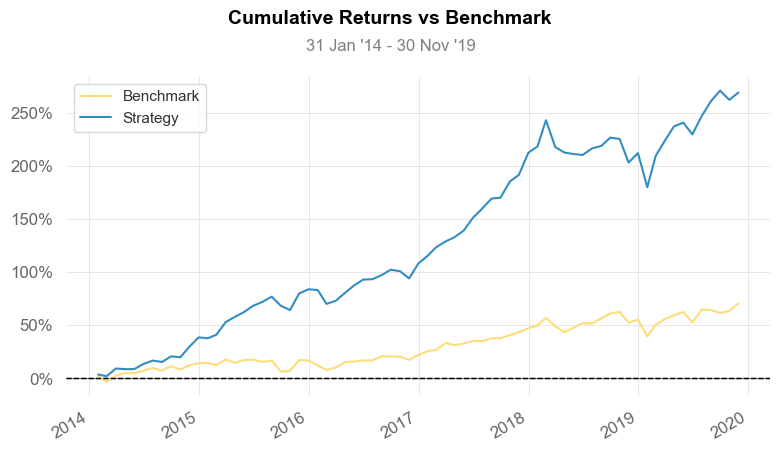

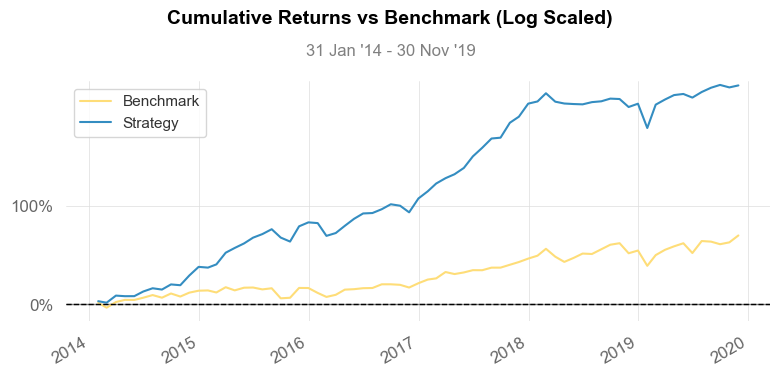

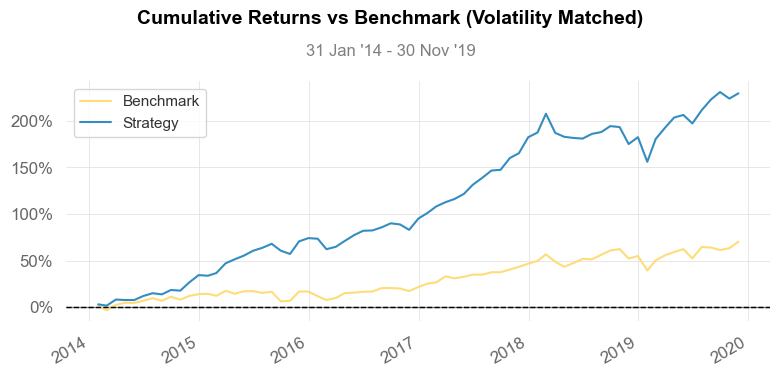

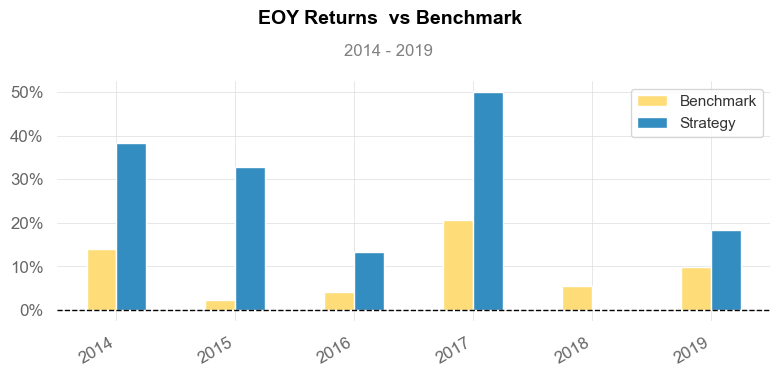

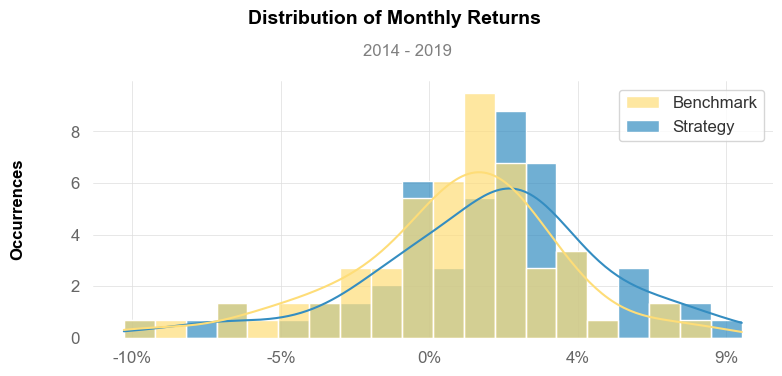

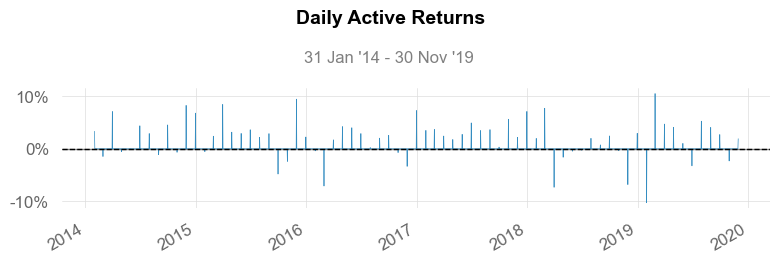

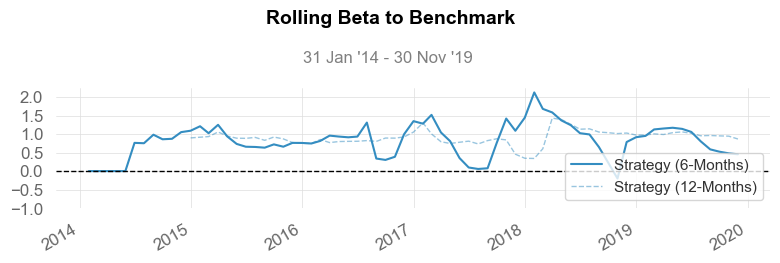

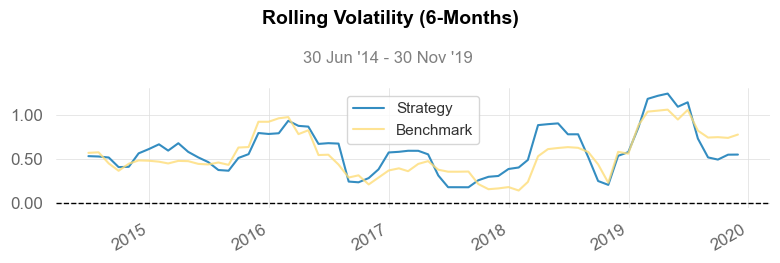

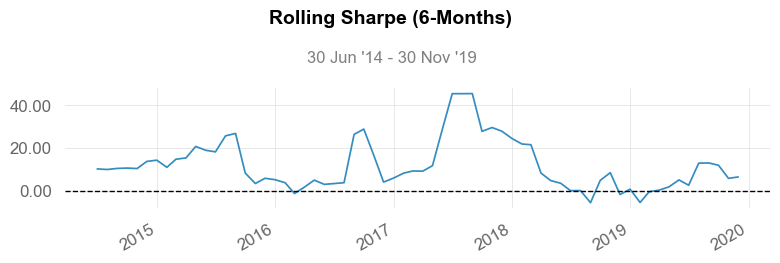

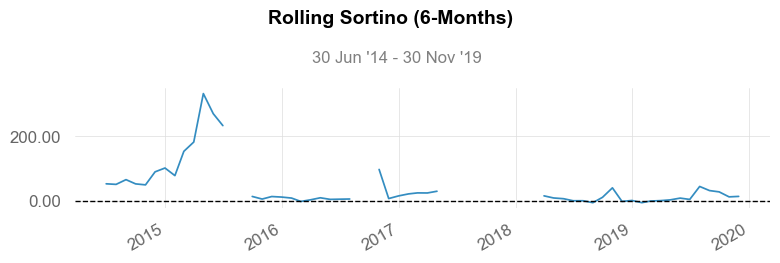

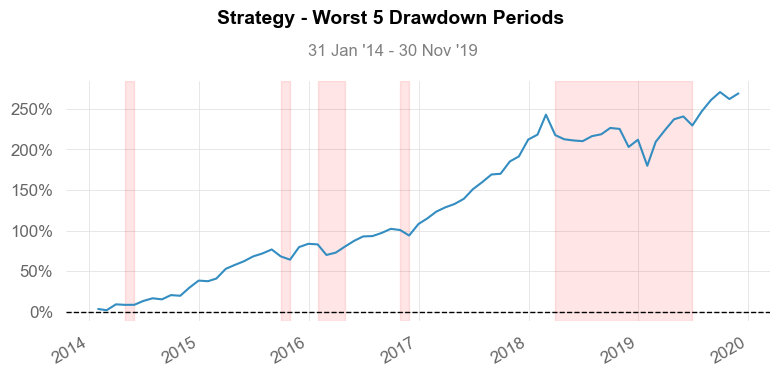

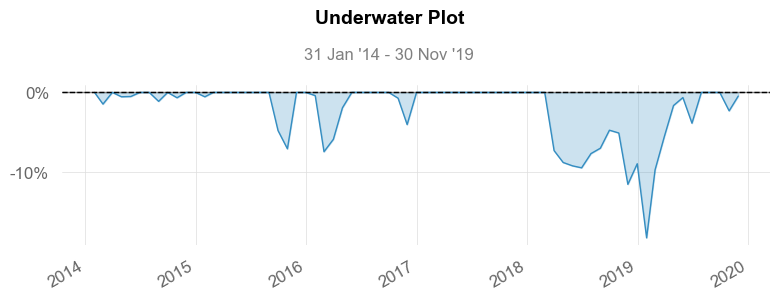

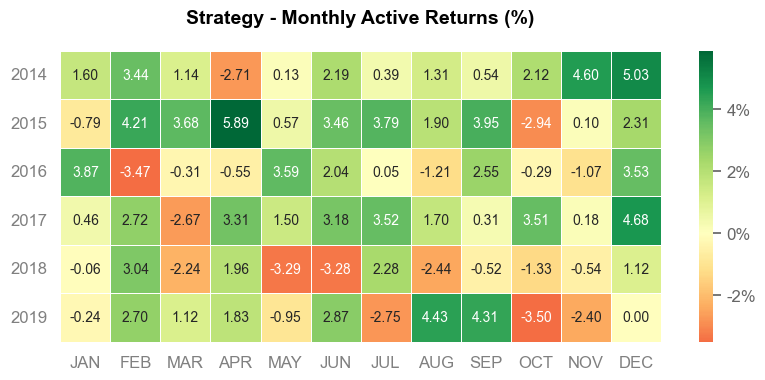

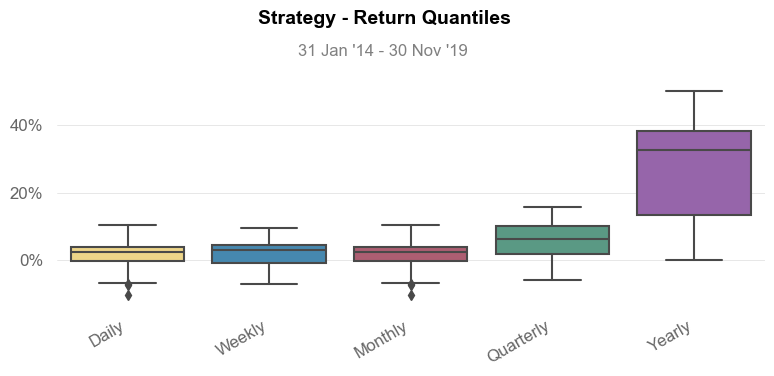

In [108]:
# Get SP500 Benchmark
import pyfolio as pf
sp500 = pd.read_csv(DATA_DIR + 'GSPC.csv', index_col='Date', parse_dates=True)
mask = (sp500.index >= datetime(2013, 12, 1)) & (sp500.index <= datetime(2019, 11, 30))
sp500 = sp500.loc[mask]
sp500 = sp500['Close']
sp500 = sp500.resample('M').first().pct_change().dropna()  
optimized_portfolio = portfolio['Portfolio_Return']

portfolio.index = sp500.index
print("Optimized Portfolio:")
print(optimized_portfolio)

print("\nS&P 500 Benchmark:")
print(sp500)

print("Optimized Portfolio Shape:", optimized_portfolio.shape)
print("S&P 500 Shape:", sp500.shape)
optimized_portfolio_df = pd.DataFrame({'returns': optimized_portfolio})

combined_df = pd.concat([optimized_portfolio_df, sp500], axis=1)

# Display the combined DataFrame
print("Combined DataFrame:")
print(combined_df)
#pf.create_full_tear_sheet(returns=combined_df)

# Generate the performance report
#qs.reports.basic(combined_df)
qs.reports.full(optimized_portfolio , benchmark=sp500, periods_per_year=12)
